In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_pdp_interactions,plot_features_custom

# Data

### Loading Dataset

In [2]:
data_path = 'Data\heart.csv'

# Carregando base
data = pd.read_csv(data_path)
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Contagem de instâncias por classe

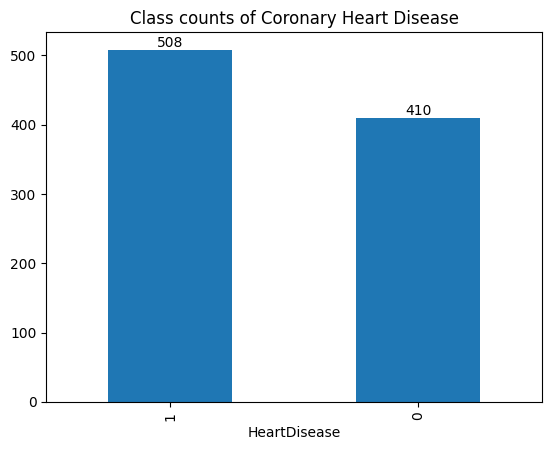

In [3]:
data['HeartDisease'].value_counts().plot(kind='bar')

for i, count in enumerate(data['HeartDisease'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Class counts of Coronary Heart Disease')
plt.show()

Como pode ser visto acima o dataset é apenas levemente desbalanceado, devido a isso não focarei em tecnicas de balanceamento

Dataset construido a partir a união de 4 datasets de problemas coronários, unificados pelos atributos em comum. Disponível em:

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

*Attribute Information*

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]


#### Verificando se existem valores nulos e/ou iguais a zero

In [4]:
missing_values = data.isnull().sum()
missing_values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
zero_values_per_class = data.groupby('HeartDisease').apply(lambda x: (x == 0).sum())
zero_values_per_class

C:\Users\gabri\AppData\Local\Temp\ipykernel_3976\2755979833.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_values_per_class = data.groupby('HeartDisease').apply(lambda x: (x == 0).sum())


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
HeartDisease,,,,,,,,,,,,
0,0,0,0,0,20,366,0,0,0,244,0,410
1,0,0,0,1,152,338,0,0,0,124,0,0


Como pode ser visto acima, a contagem de Cholesterol zero é majoritariamente presente na coluna com problema de coração. Isso é GRAVÍSSIMO pois pode resultar em uma correlação inversa do modelo entre colesterol e problema de coração (o que seria absurdo).

Das colunas que possuem 0 Temos:

- Cholesterol: Não deve ser zero nunca, provavelmente o paciente marcou e não realizou o exame. SERÁ SUBSTITUIDO PELA MEDIANA DA CLASSE EM QUESTÃO;

- FastingBS: variável binária, esperado que tenha zeros

- RestingBP: Pressão sanguinea, não deve ser zero nunca, substituirei pela mediana;

- Oldpeak: Pode ser zero pelo método em que a medida é realizada (https://www.ncbi.nlm.nih.gov/books/NBK459364/)

- HeartDisease: variável binária, esperado a presença de zeros;

#### Pré-processando dados

Os seguintes processos foram realizados:

1. **Codificação de Variáveis Categóricas**:
   - **Sexo**: O sexo dos pacientes é codificado como `{`M`: 1, 'F': 2}`, onde 'M' representa Masculino e 'F' representa Feminino.
   - **Tipo de Dor no Peito (ChestPainType)**: Os tipos de dor no peito são re-codificados para refletir a gravidade dos sintomas de maneira que `{'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0}`. Aqui, 'TA' (Angina Típica) recebe o valor mais alto (3) por ser o tipo mais preocupante de dor no peito, seguido por 'ATA' (Angina Atípica) e 'NAP' (Dor Não Anginal), enquanto 'ASY' (Assintomático) recebe o valor mais baixo (0) por não apresentar sintomas visíveis.
   - **ECG em Repouso (RestingECG)**: Os resultados do eletrocardiograma em repouso são codificados como `{'Normal': 0, 'ST': 1, 'LVH': 2}`, onde 'Normal' indica um ECG sem anormalidades, 'ST' indica anormalidades na onda ST e 'LVH' indica hipertrofia ventricular esquerda.
   - **Angina Induzida por Exercício (ExerciseAngina)**: Esta variável é codificada como `{'Y': 1, 'N': 0}`, onde 'Y' indica a presença de angina induzida por exercício e 'N' a ausência.
   - **Inclinação do ST durante Exercício (ST_Slope)**: A inclinação do segmento ST é codificada como `{'Up': 1, 'Flat': 0, 'Down': -1}`, refletindo a resposta do segmento ST durante o esforço físico, onde uma inclinação para cima ('Up') é considerada normal.

2. **Tratamento de Valores Nulos**:
   - **Pressão Arterial em Repouso (RestingBP)** e **Colesterol**: Para essas duas variáveis, os valores nulos (representados por zeros) são substituídos pela mediana dos valores não nulos dentro de cada categoria de doença cardíaca (`HeartDisease`). Isso é feito para cada grupo (presença ou ausência de doença cardíaca), garantindo que os valores substituídos sejam representativos da distribuição dos dados sem os valores nulos.


In [6]:
def transform_heart_data(data):

    encoding_maps = {
        'Sex': {'M': 1, 'F': 2},
        'ChestPainType': {'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0},
        'RestingECG': {'Normal': 0, 'ST': 1, 'LVH': 2},
        'ExerciseAngina': {'Y': 1, 'N': 0},
        'ST_Slope': {'Up': 1, 'Flat': 0, 'Down': -1}
    }

    data = data.copy()
    for column, mapping in encoding_maps.items():
        data[column] = data[column].map(mapping)
        print(f"Encoded {column} with mapping {mapping}.")

    for column in ['RestingBP', 'Cholesterol']:
        median_values = data[data[column] != 0].groupby('HeartDisease')[column].median()
        print(f"Substituting {column} zeros with the medians {median_values[0]} and {median_values[1]} for group 0 and 1.")
        data.loc[data[column] == 0, column] = data.loc[data[column] == 0, 'HeartDisease'].map(median_values).astype(int)

    return data

transformed_data = transform_heart_data(data)

Encoded Sex with mapping {'M': 1, 'F': 2}.
Encoded ChestPainType with mapping {'TA': 3, 'ATA': 2, 'NAP': 1, 'ASY': 0}.
Encoded RestingECG with mapping {'Normal': 0, 'ST': 1, 'LVH': 2}.
Encoded ExerciseAngina with mapping {'Y': 1, 'N': 0}.
Encoded ST_Slope with mapping {'Up': 1, 'Flat': 0, 'Down': -1}.
Substituting RestingBP zeros with the medians 130.0 and 132.0 for group 0 and 1.
Substituting Cholesterol zeros with the medians 231.5 and 246.0 for group 0 and 1.


#### Apresentando dados antes e depois do pré-processamento

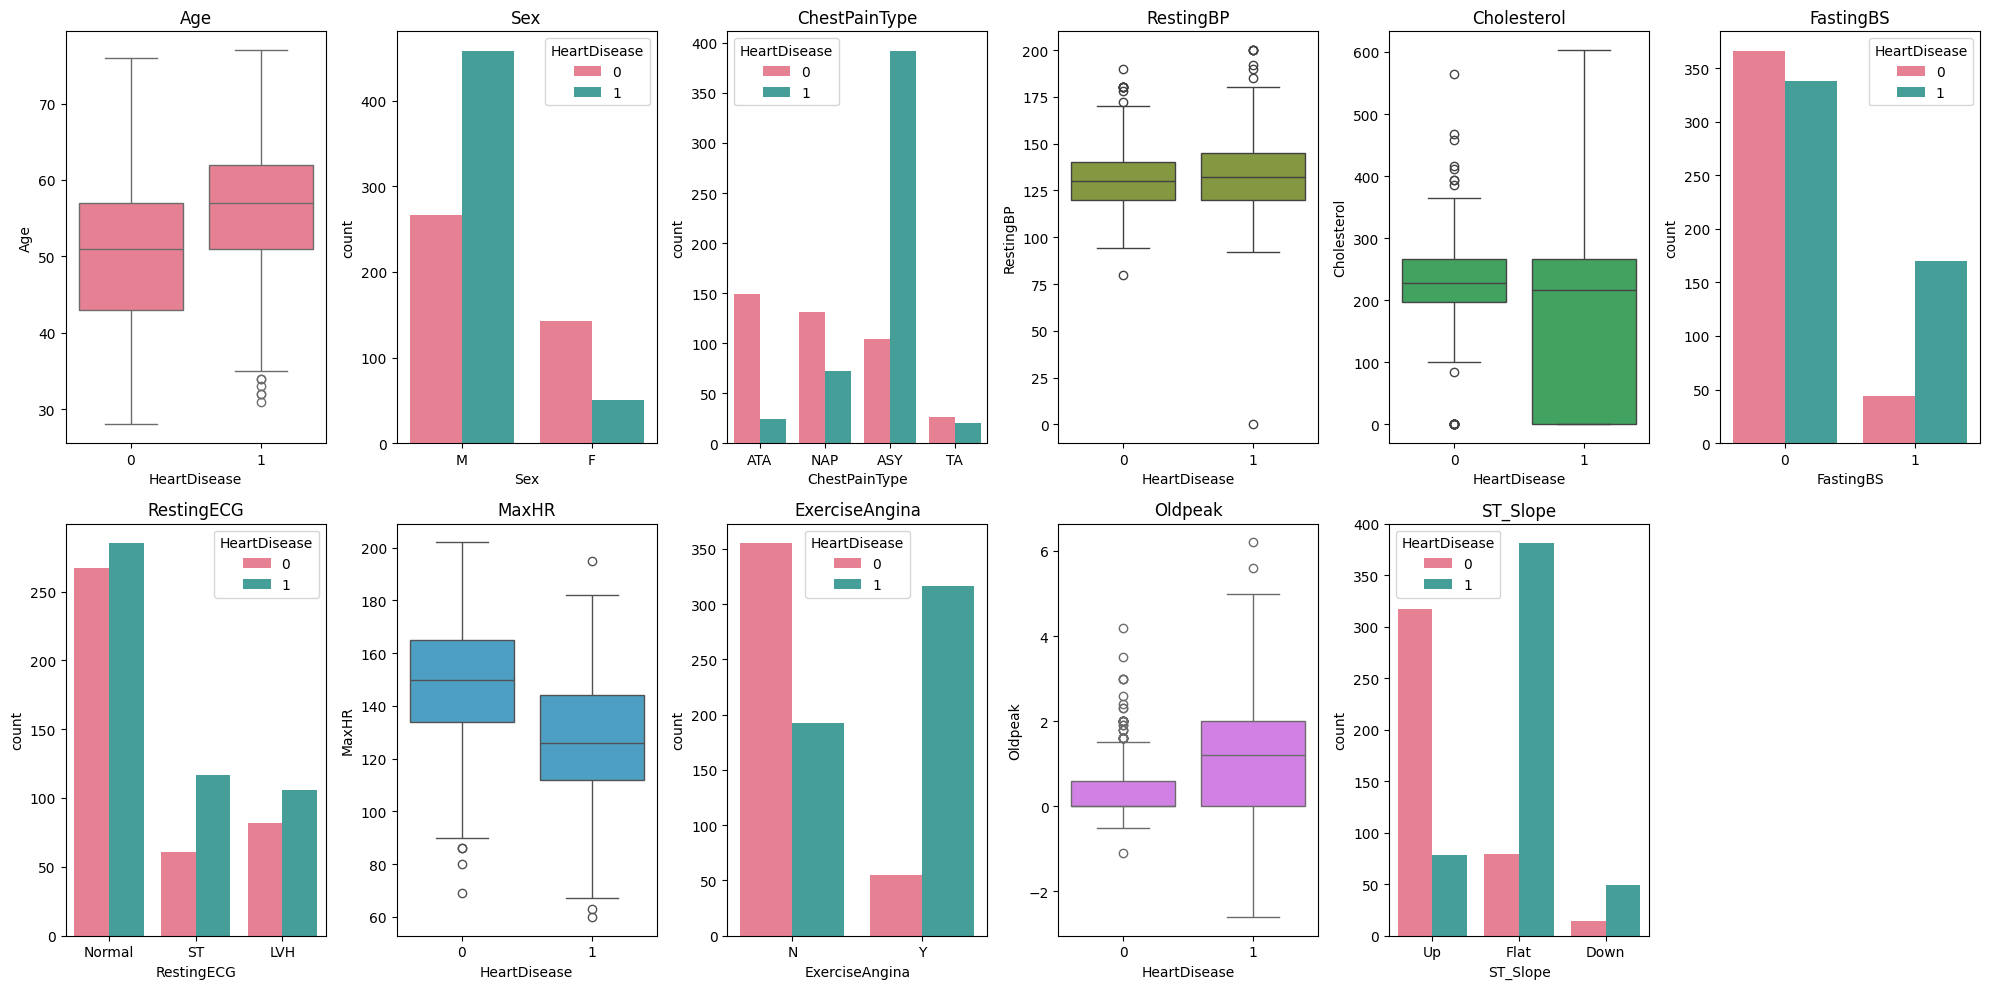

In [7]:
plot_features_custom(data, ncols=6, plot_types=['b', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'b', 'c']
, outcome_name='HeartDisease')

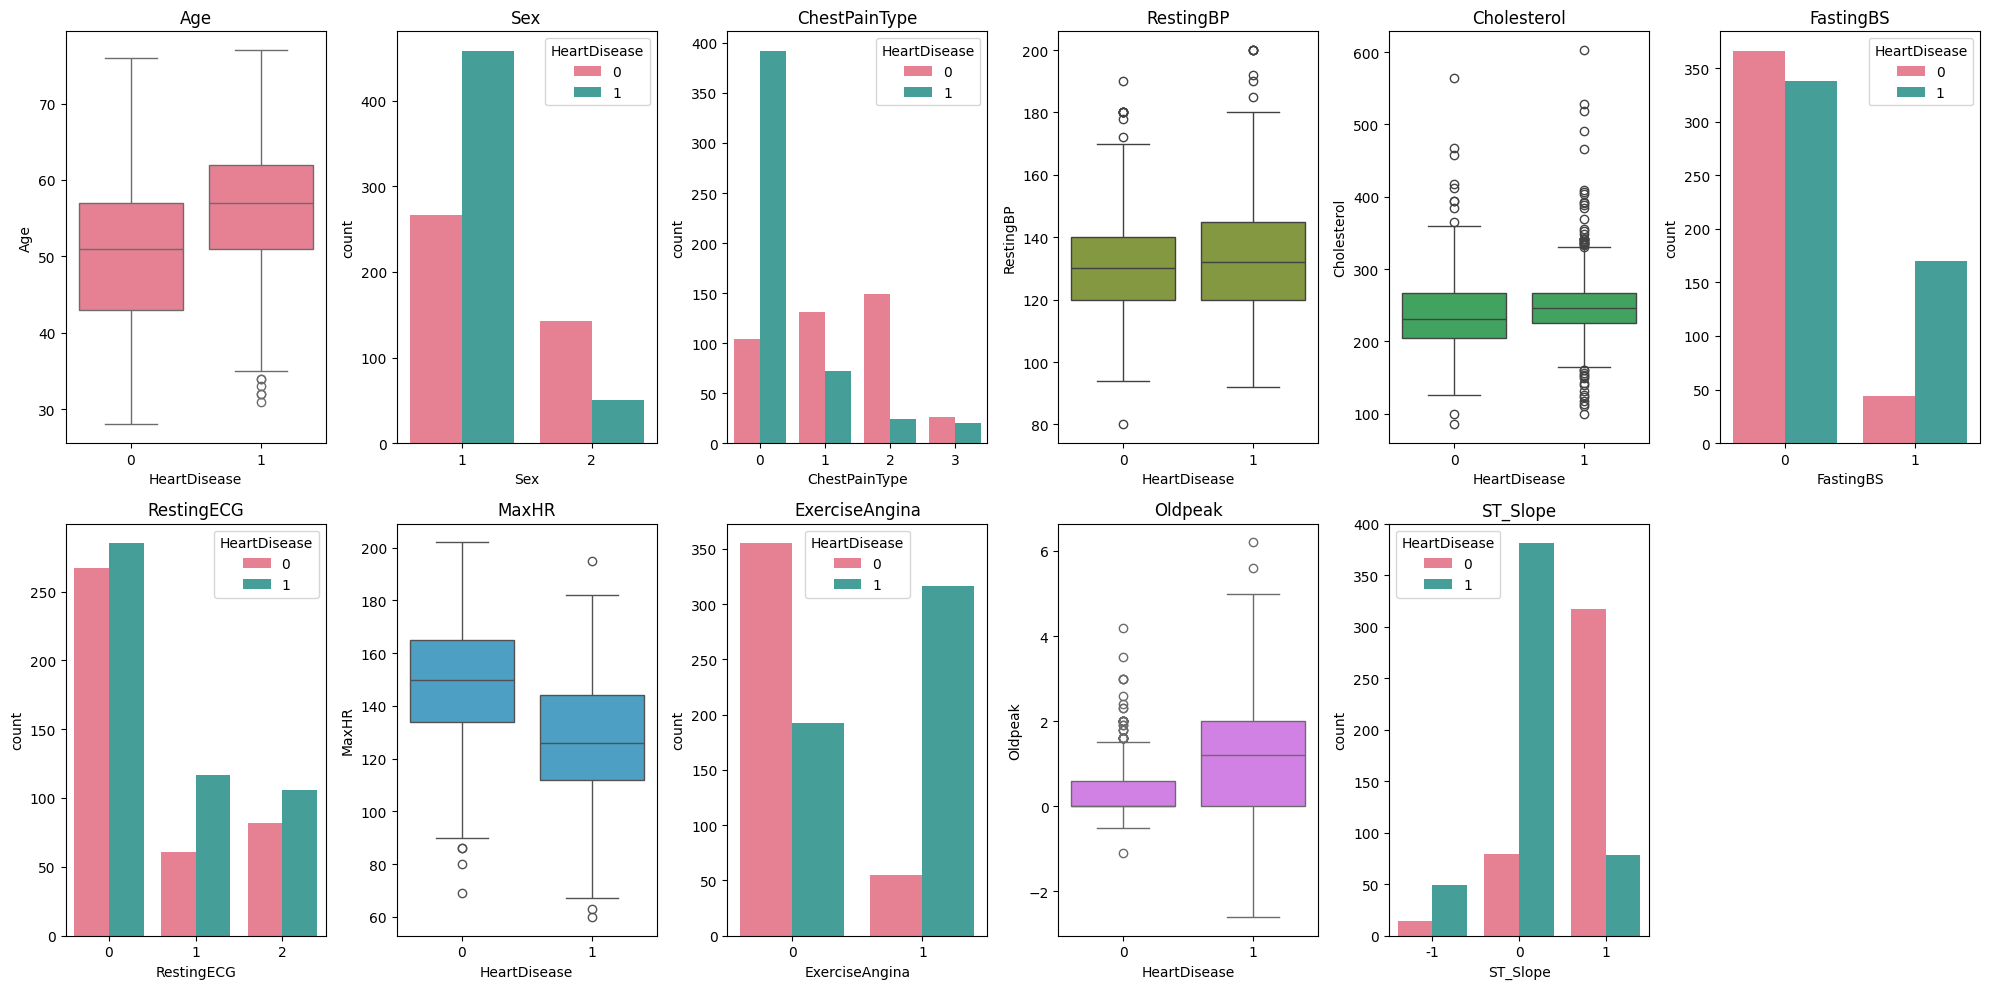

In [8]:
plot_features_custom(transformed_data, ncols=6, plot_types=['b', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'b', 'c'], outcome_name='HeartDisease')

No plot acima é possível observar a mudança significativa na coluna de Colesterol. Além disso, é possível observar também a codificação das colunas de features categoricos. Todas foram codificados com sequências numéricas ordenadas em nível de gravidade da categoria em questão para a feature analisada.

# Treinando modelos

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


# Dividir dados
X = transformed_data.drop('HeartDisease', axis=1)
y = transformed_data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'MLP Classifier': make_pipeline(StandardScaler(), MLPClassifier(random_state=42,max_iter= 2000)),
    'Random Forest': RandomForestClassifier()

}


# Treinar modelos
for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Training Logistic Regression
Logistic Regression trained.
Training Decision Tree
Decision Tree trained.
Training MLP Classifier
MLP Classifier trained.
Training Random Forest
Random Forest trained.


# Analise de incerteza

In [18]:
from scipy.stats import entropy

def model_uncertainty(model, X):
    probs = model.predict_proba(X)
    return entropy(probs.T)  # Calcular entropia

# Avaliação e cálculo de incerteza
model_entropies = {}
for name, model in models.items():
    uncertainty = model_uncertainty(model, X_test)
    model_entropies[name] = uncertainty
    print(f"Uncertainty calculated for {name}.")


Uncertainty calculated for Logistic Regression.
Uncertainty calculated for Decision Tree.
Uncertainty calculated for MLP Classifier.
Uncertainty calculated for Random Forest.


In [28]:
aleatoric_uncertainty = np.mean(list(model_entropies.values()), axis=0)
epistemic_uncertainty = np.var(list(model_entropies.values()), axis=0)
print("Aleatoric and epistemic uncertainties calculated.")


Aleatoric and epistemic uncertainties calculated.


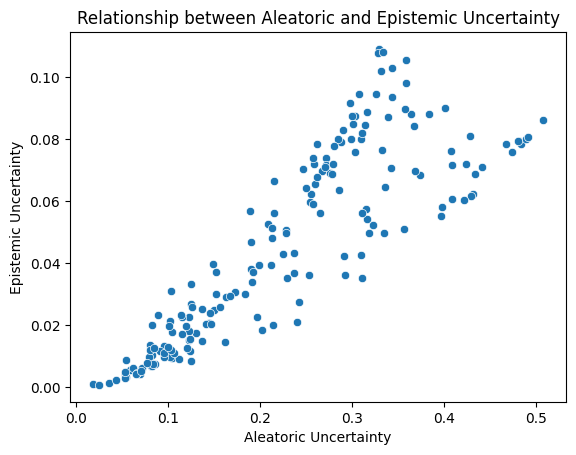

In [20]:
import seaborn as sns

sns.scatterplot(x=aleatoric_uncertainty, y=epistemic_uncertainty)
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Epistemic Uncertainty')
plt.title('Relationship between Aleatoric and Epistemic Uncertainty')
plt.show()

In [29]:
# Adicionando incertezas ao dataset
X_test_with_uncertainty = X_test.copy()
X_test_with_uncertainty['Aleatoric Uncertainty'] = aleatoric_uncertainty
X_test_with_uncertainty['Epistemic Uncertainty'] = epistemic_uncertainty

# Correlação
correlation_matrix = X_test_with_uncertainty.corr()[['Aleatoric Uncertainty', 'Epistemic Uncertainty']]
# order correlation matrix by uncertainty value
correlation_matrix.
print(correlation_matrix)


                       Aleatoric Uncertainty  Epistemic Uncertainty
Age                                 0.128832               0.114716
Sex                                -0.011127               0.057316
ChestPainType                       0.054007               0.016196
RestingBP                          -0.214008              -0.223833
Cholesterol                         0.090045               0.102048
FastingBS                          -0.011024               0.023929
RestingECG                          0.142713               0.072727
MaxHR                               0.017079               0.010808
ExerciseAngina                     -0.039701              -0.129252
Oldpeak                             0.054956               0.035581
ST_Slope                            0.044928              -0.000219
Aleatoric Uncertainty               1.000000               0.863560
Epistemic Uncertainty               0.863560               1.000000


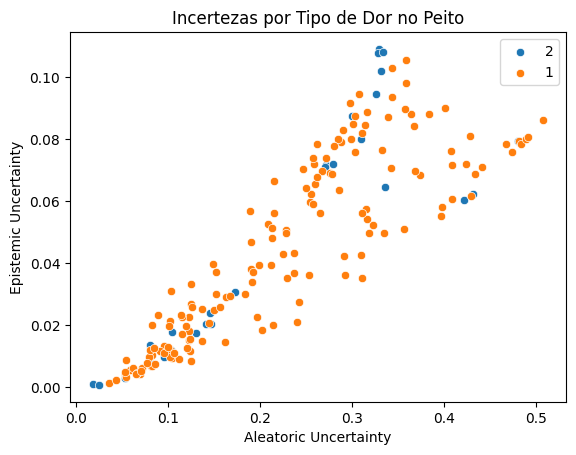

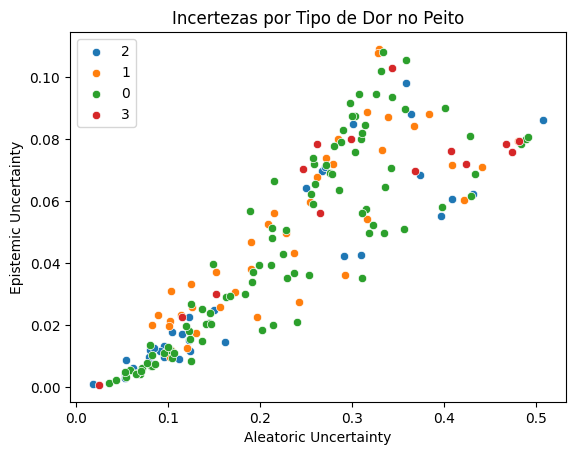

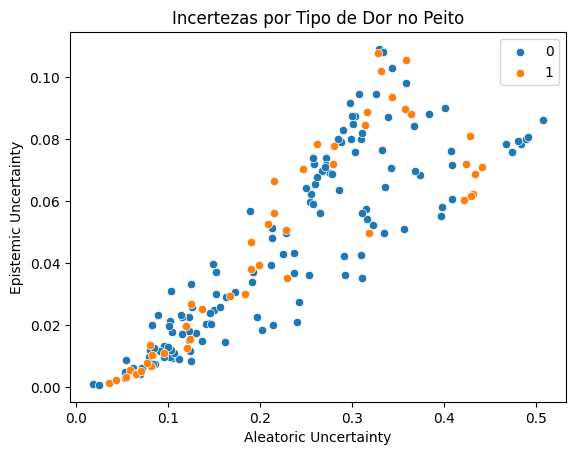

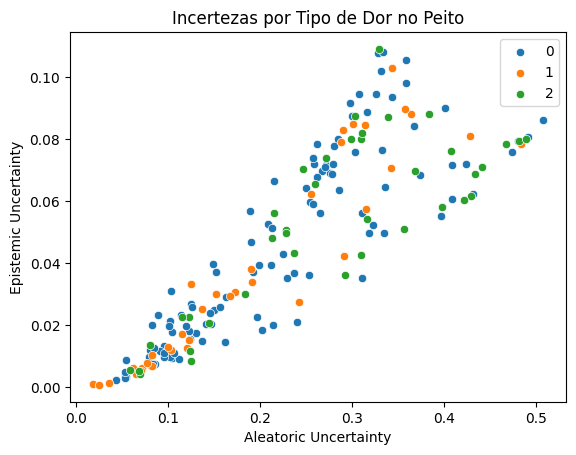

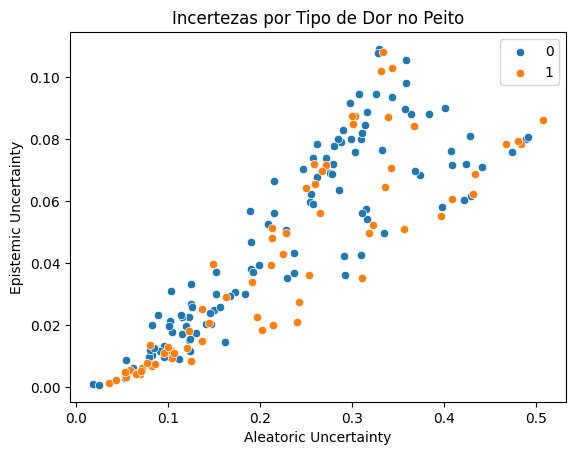

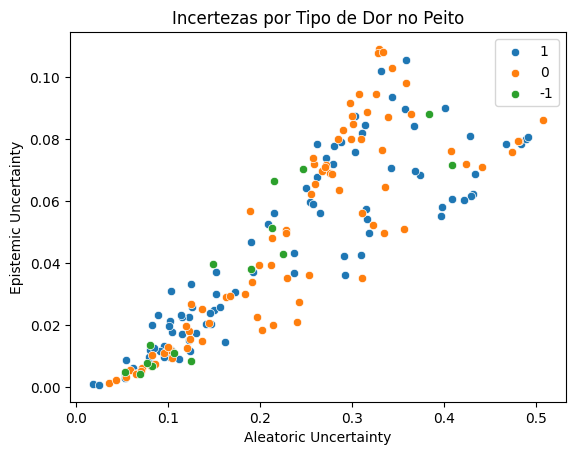

In [36]:
column_types = ['b', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'b', 'c']
for i,column in enumerate(X_test.columns):
    if column_types[i] == 'c':
        for category in X_test[column].unique():
            subset = X_test_with_uncertainty[X_test[column] == category]
            sns.scatterplot(data=subset, x='Aleatoric Uncertainty', y='Epistemic Uncertainty', label=str(category))
        plt.legend()
        plt.title('Incertezas por Tipo de Dor no Peito')
        plt.show()


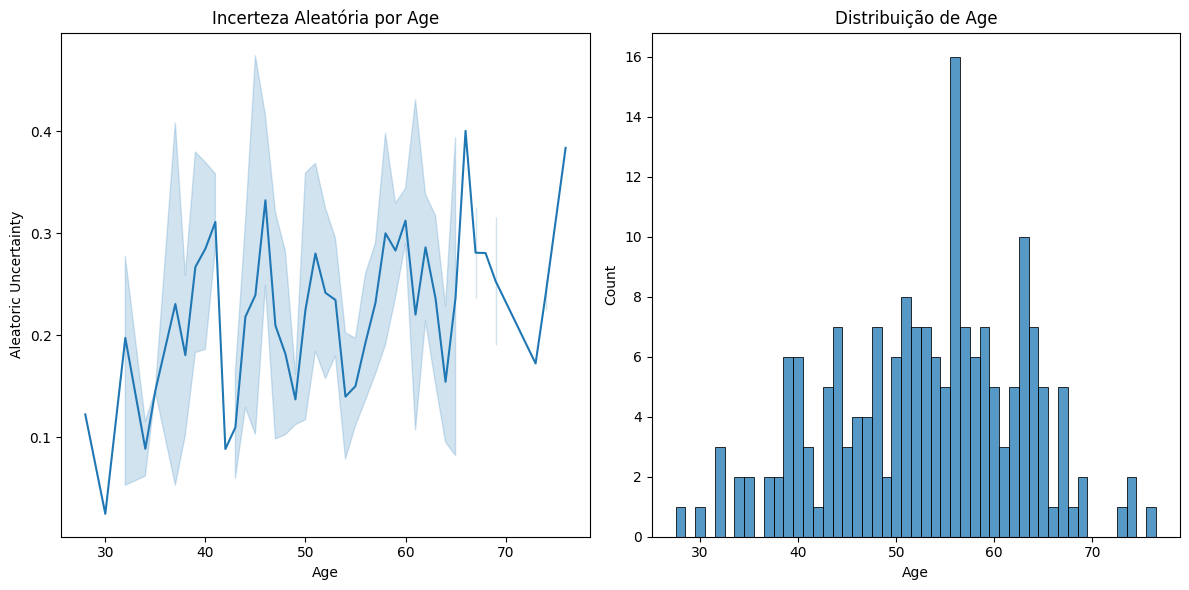

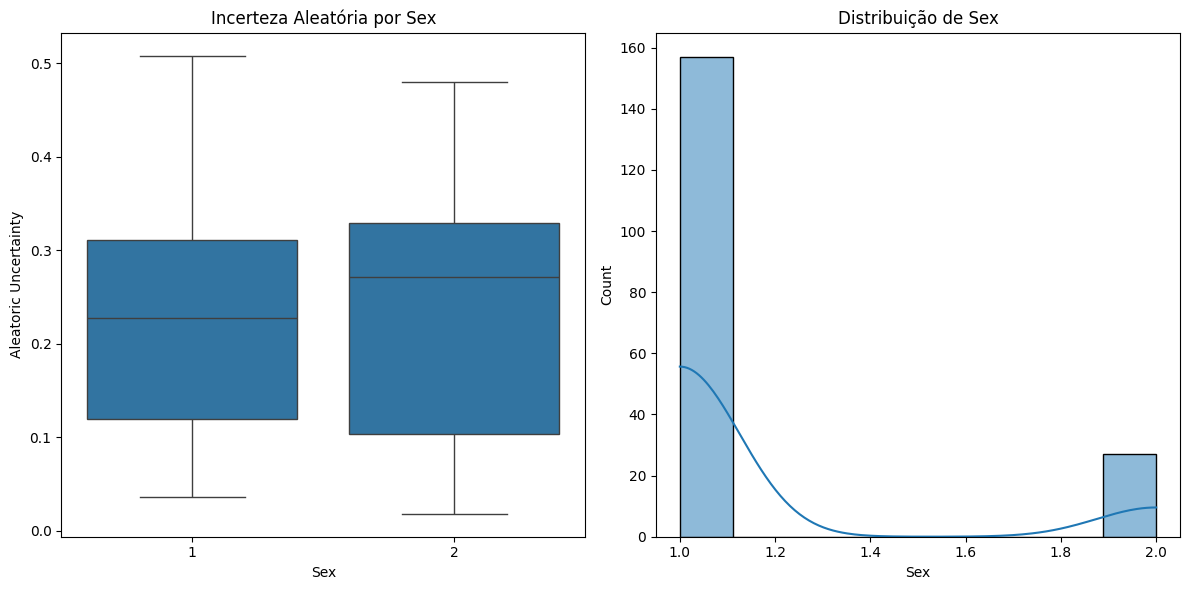

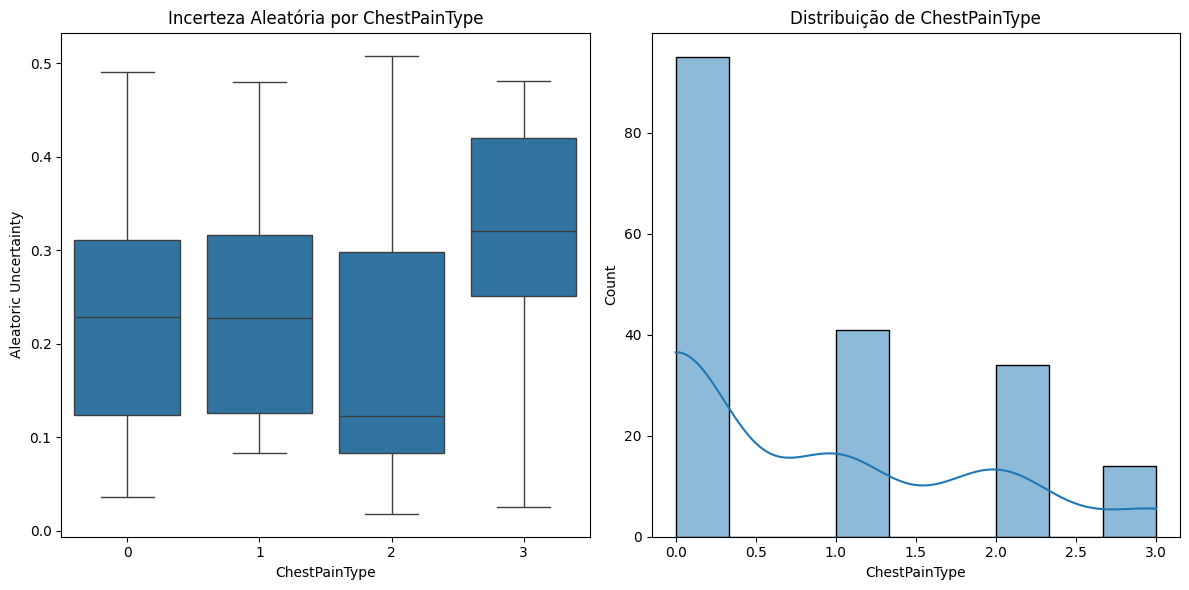

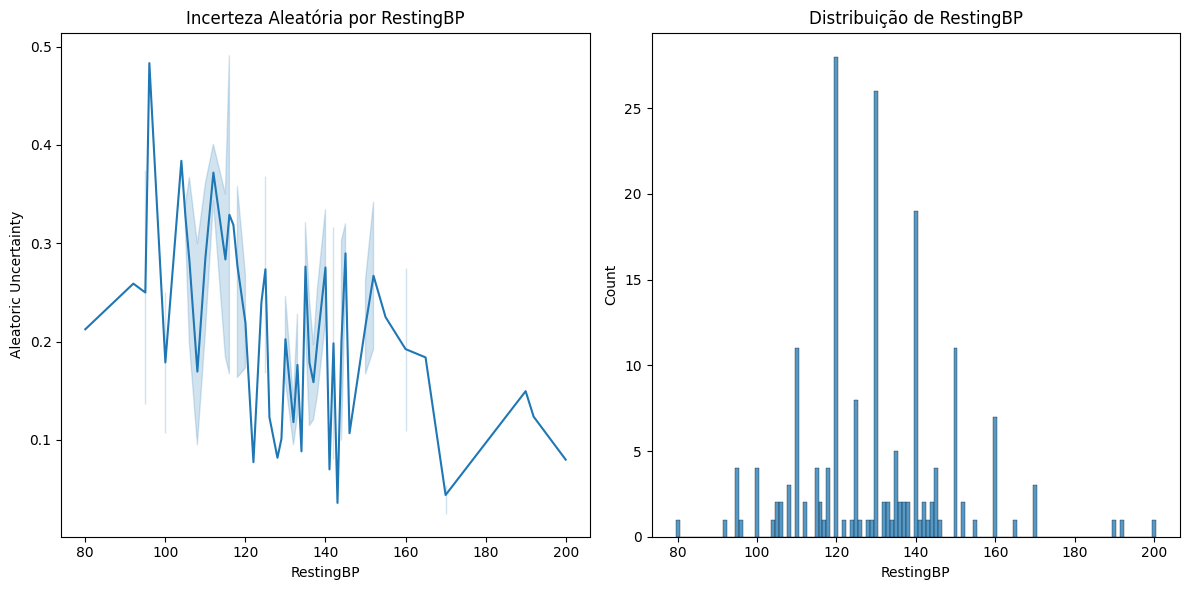

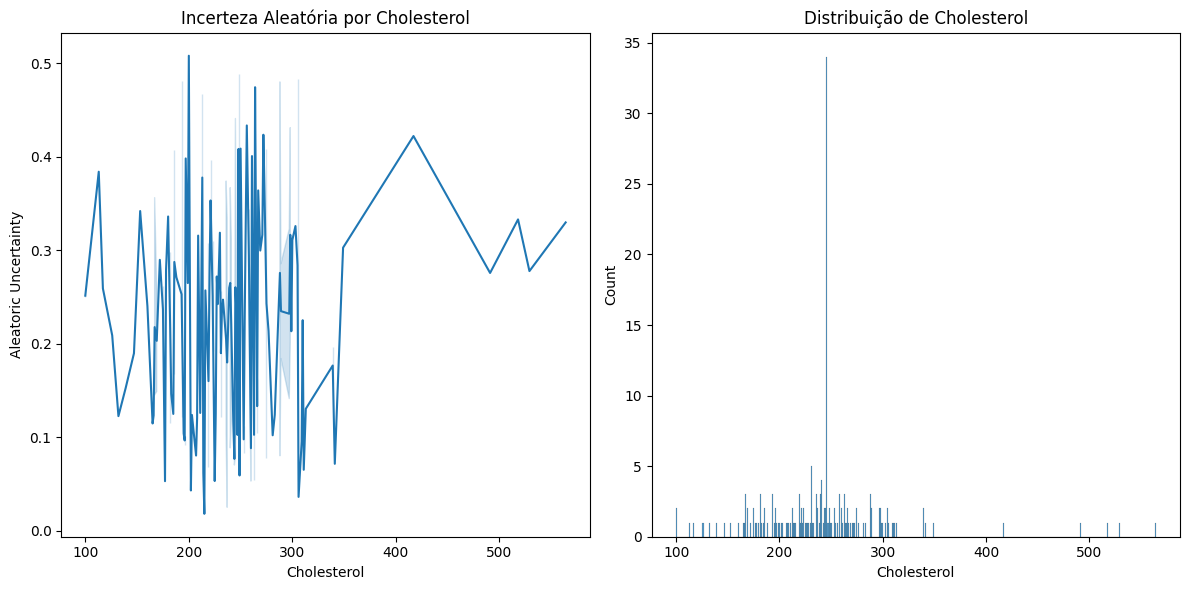

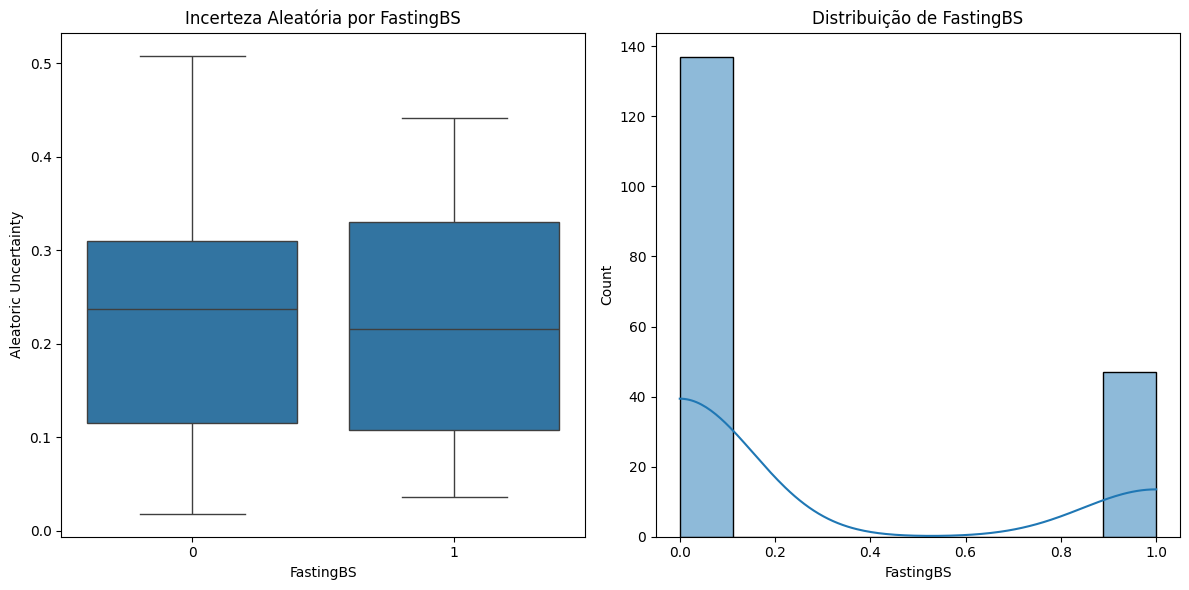

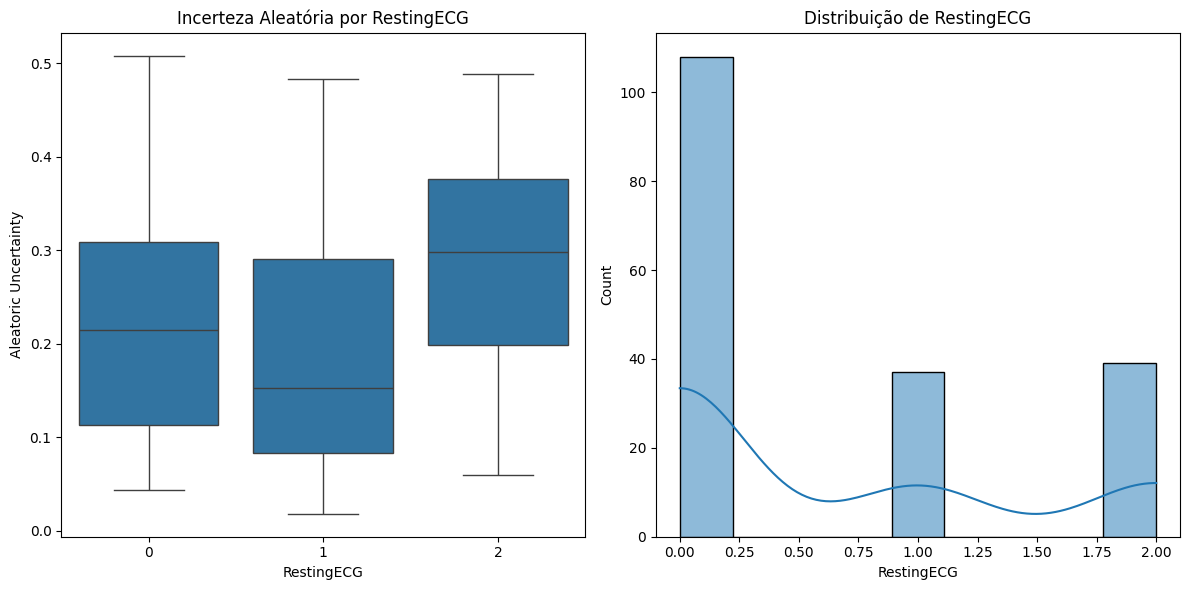

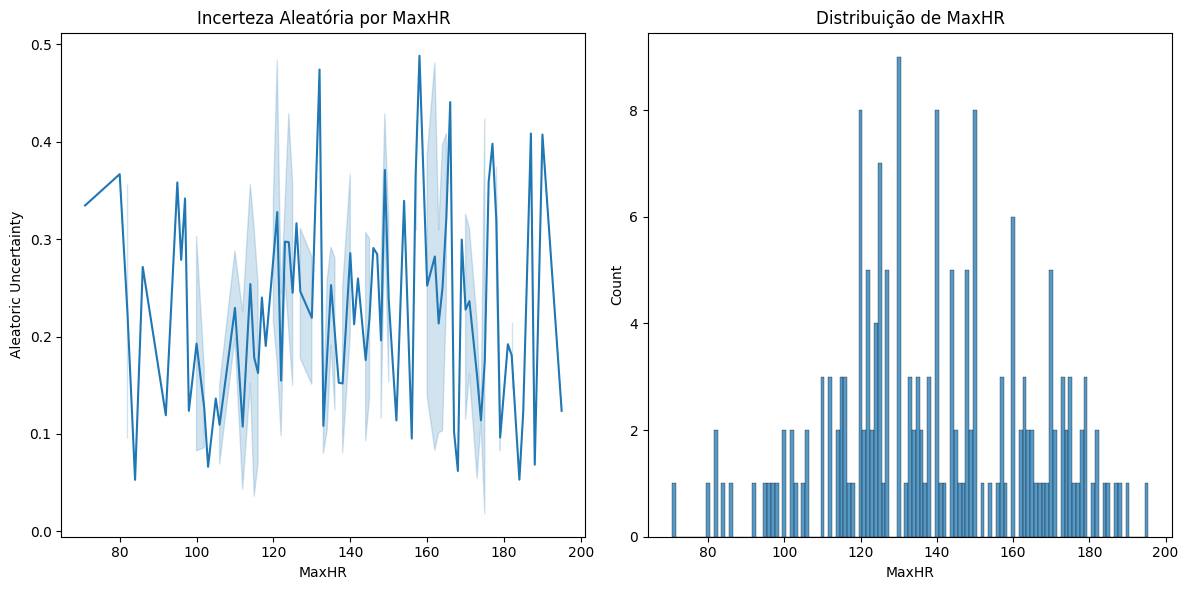

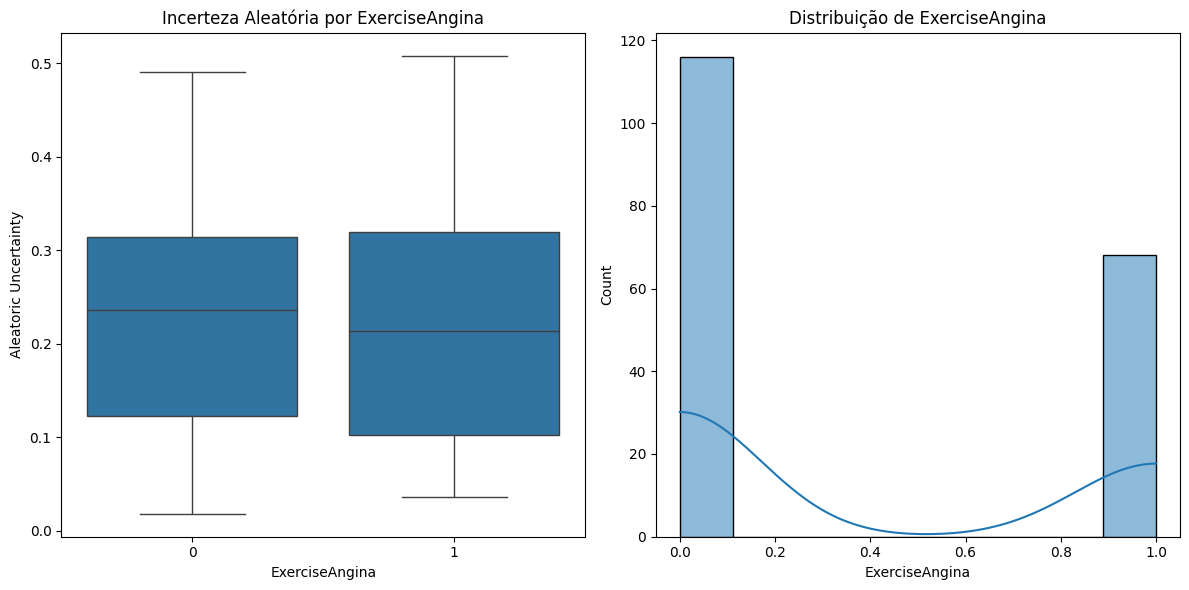

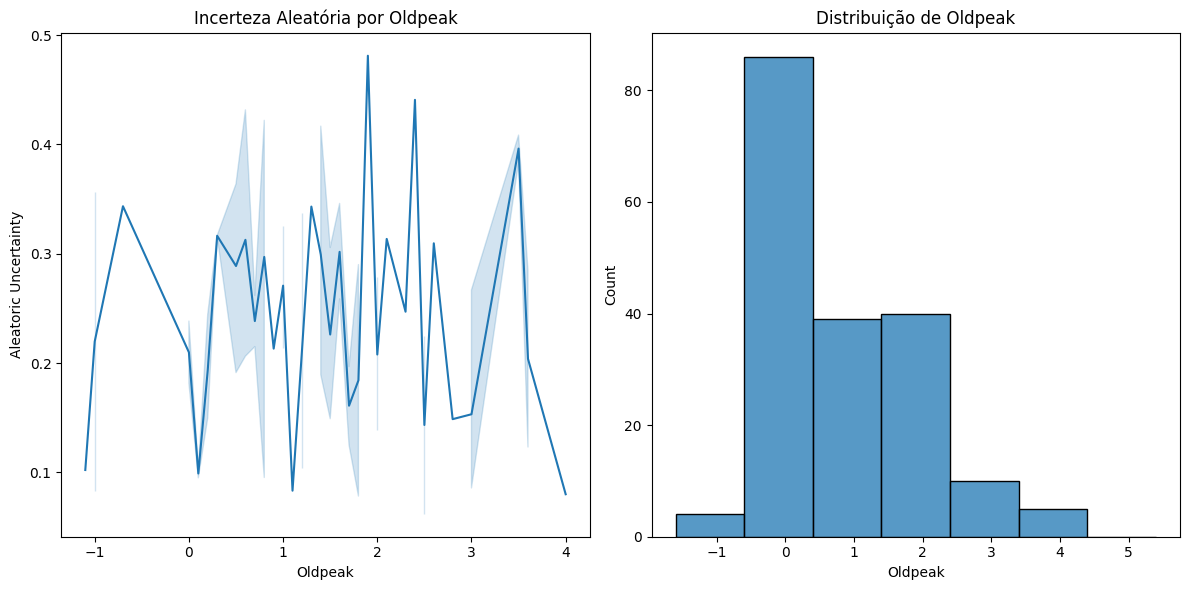

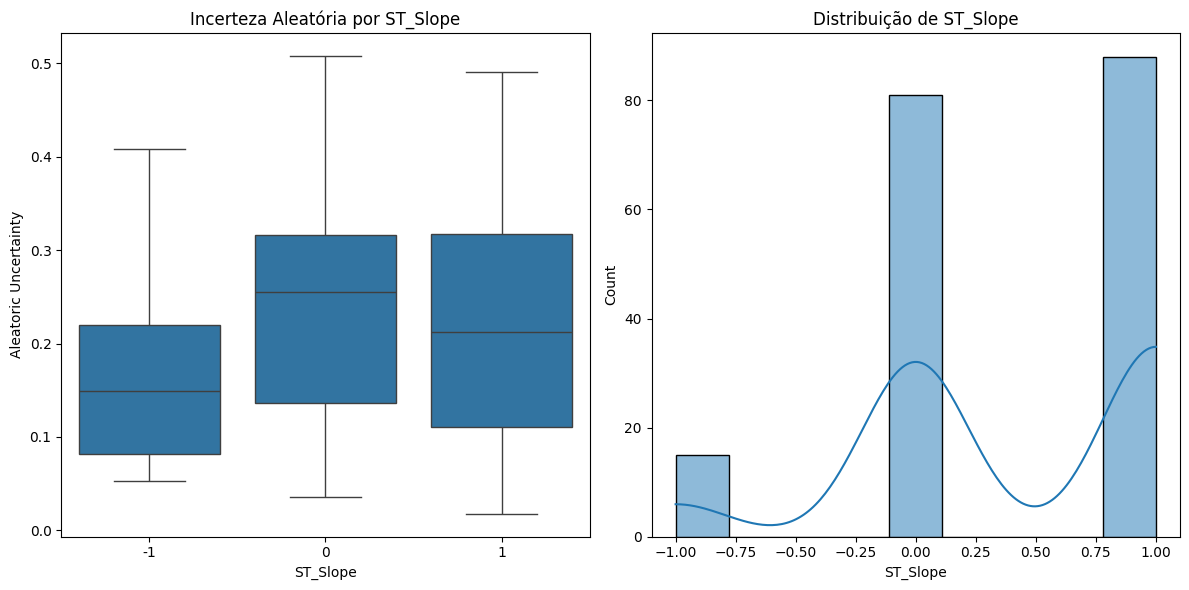

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo tipos de colunas como no seu exemplo
column_types = ['b', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'b', 'c']

# Loop para plotar gráficos para cada feature
for i, column in enumerate(X_test.columns):
    # Criando subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot para variáveis binárias ou categóricas
    if column_types[i] == 'b':
        # Gráfico de linha ou scatter para a incerteza em função dos valores da feature
        sns.lineplot(ax=axes[0], data=X_test_with_uncertainty, x=column, y='Aleatoric Uncertainty')
        axes[0].set_title(f'Incerteza Aleatória por {column}')

        # Histograma dos valores da feature
        sns.histplot(ax=axes[1], data=X_test, x=column, discrete=True, kde=False)
        axes[1].set_title(f'Distribuição de {column}')
    # Plot para variáveis contínuas
    else:
        # Boxplot para a incerteza em função dos valores da feature
        sns.boxplot(ax=axes[0], data=X_test_with_uncertainty, x=column, y='Aleatoric Uncertainty')
        axes[0].set_title(f'Incerteza Aleatória por {column}')

        # Histograma dos valores da feature
        sns.histplot(ax=axes[1], data=X_test, x=column, kde=True)
        axes[1].set_title(f'Distribuição de {column}')
    
    # Ajustando a visualização
    plt.tight_layout()
    plt.show()


# Conclusão

Pelos resultados, é possível observar que a base de dados, embora substancial, revela uma complexidade muito alta em relação à contagem de instâncias disponíveis. Essa complexidade é refletida pela alta correlação entre as incertezas aleatória e epistêmica, sugerindo que áreas com dados insuficientes não apenas carecem de informações mas também apresentam variabilidade significativa nos dados disponíveis. Além disso, a análise revelou uma relação clara entre a incerteza e a contagem de instâncias por categoria ou intervalo de valores para variáveis numéricas, onde categorias com menor número de instâncias tendem a exibir maior incerteza. Esse fato reforça a noção de que a complexidade observada pode ser mitigada com uma coleta de dados mais abrangente e diversificada.

Se a base de dados fosse expandida para incluir mais instâncias abrangendo uma variedade maior de condições, esperaríamos ver uma redução na incerteza epistêmica, mantendo-se a incerteza aleatória que é intrínseca à natureza dos dados. Com isso, a correlação entre as incertezas poderia diminuir, indicando que o modelo está se tornando mais robusto e menos sujeito às limitações de conhecimento sobre o processo gerador dos dados, resultando em previsões mais confiáveis e uma análise mais precisa da variabilidade natural observada. A expansão da base de dados não apenas ajudaria a reduzir a incerteza epistêmica mas também proporcionaria uma visão mais clara e menos distorcida da real influência das características variáveis no comportamento do modelo.